<h1>LOAD ALL NECESSARY LIBRARIES</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
# nltk.download('vader_lexicon')
import nltk.corpus
import os
import sys
import json
from collections import Counter
import swifter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import swifter
from ipywidgets import FloatProgress
from tqdm import tqdm

<h1>Load the json File</h1>

In [2]:
filename="Cell_Phones_and_Accessories"

In [3]:
filepath = ('Datasets/'+filename+'.json')
df_raw = pd.read_json(filepath,lines=True)

In [4]:
df_raw.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,5,False,"11 19, 2014",A1GG51FWU0XQYH,098949232X,Paul Williams,If your into space this is the Calendar for you.,Five Stars,1416355200,NaN,NaN,NaN
1,5,False,"11 19, 2014",AVFIDS9RK38E0,098949232X,Sean Powell,Awesome pictures!,Five Stars,1416355200,NaN,NaN,NaN
2,5,False,"11 19, 2014",A2S4AVR5SJ7KMI,098949232X,Tom Davis,Great wall art and information for space explo...,Five Stars,1416355200,NaN,NaN,NaN
3,5,False,"11 19, 2014",AEMMMVOR9BFLI,098949232X,Kwajmeck,"As always, it is a quality calendar full of ve...",I love it. I buy a new one every year,1416355200,NaN,NaN,NaN
4,5,False,"11 19, 2014",A2DZXMBTY7KLYP,098949232X,ScottG43,This is a fantastic calendar. This is my third...,Great Calendar.,1416355200,NaN,NaN,NaN


<h1>Generate sentiment</h1>

In [5]:

# nltk.download('vader_lexicon')
sentiment = SentimentIntensityAnalyzer()
sid_obj = SentimentIntensityAnalyzer()
def get_compound_score(text):
    return sid_obj.polarity_scores(str(text))['compound']


df_raw['sentiment']=df_raw['reviewText'].swifter.apply(get_compound_score)
# sid_obj.polarity_scores(df_raw['reviewText'][0])['compound']

count=0
avg_rating=0
comp_rating=0
for index, row in df_raw.iterrows():
    ss = sentiment.polarity_scores(str(row['reviewText']))
    #to get compound, negetive, neutral, positive score
    for k in sorted(ss):
        compound_score =ss['compound']
        #print(f"ss: {compound_score}")
    #f.write(f"ss[{count}]:{(compound_score+1)/2.0*5.0}\n")
    
    avg_rating+=(compound_score+1)/2.0*5.0
    comp_rating+=(row.overall+compound_score/5.0)*(5/6)
    #f.write(sentences)
    #f.write("\n")
    count+=1
    
# Calculate final average rating if count is greater than 0 to avoid division by zero
if count > 0:
    avg_rating /= count
    comp_rating /= count


Pandas Apply:   0%|          | 0/10063255 [00:00<?, ?it/s]

<h1>Save and Load the Sentiment file</h1>

In [6]:
#Backup all the modifications in csv file
df_raw.to_csv('output/'+filename+'.csv', index=False)
df_raw=pd.read_csv('output/'+filename+'.csv')

C:\Users\SUBHASHIS\AppData\Local\Temp\ipykernel_18612\2721690646.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw=pd.read_csv('output/'+filename+'.csv')


In [7]:
df_raw['reviewTime'] = pd.to_datetime(df_raw['unixReviewTime'], unit='s')
#Filter now
# df_raw=df_raw.loc[df_raw.reviewTime>='2013-01-01']
df_raw.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style,sentiment
0,5,False,2014-11-19,A1GG51FWU0XQYH,098949232X,Paul Williams,If your into space this is the Calendar for you.,Five Stars,1416355200,NaN,NaN,NaN,0.0000
1,5,False,2014-11-19,AVFIDS9RK38E0,098949232X,Sean Powell,Awesome pictures!,Five Stars,1416355200,NaN,NaN,NaN,0.6588
2,5,False,2014-11-19,A2S4AVR5SJ7KMI,098949232X,Tom Davis,Great wall art and information for space explo...,Five Stars,1416355200,NaN,NaN,NaN,0.7184
3,5,False,2014-11-19,AEMMMVOR9BFLI,098949232X,Kwajmeck,"As always, it is a quality calendar full of ve...",I love it. I buy a new one every year,1416355200,NaN,NaN,NaN,0.8016
4,5,False,2014-11-19,A2DZXMBTY7KLYP,098949232X,ScottG43,This is a fantastic calendar. This is my third...,Great Calendar.,1416355200,NaN,NaN,NaN,0.8689


<h1>Now group by reviewTime for 1 Week</h1>
<h3>reviewCount-> count all reviews in a week</h3>
<h3>sentiment-> mean of all sentiments for diff products in a week</h3>
<h3>overall->mean of all ratings in a week</h3>
<h3>helpfulness->count of the number of people who liked the review</h3>

In [8]:

df_grouped = df_raw.groupby(pd.Grouper(key='reviewTime', freq='7D')).agg(
    review_count=('reviewerID', 'count'),
    average_sentiment=('sentiment', 'mean'),
    average_rating=('overall', 'mean'),
    helpfulness=('vote','count')
).reset_index()

In [9]:
df_grouped=df_grouped.fillna(0)
df_grouped.set_index('reviewTime', inplace=True)
df_grouped.head()

,review_count,average_sentiment,average_rating,helpfulness
reviewTime,,,,
1999-10-31,1,0.4966,4.0,1
1999-11-07,0,0.0000,0.0,0
1999-11-14,1,0.0000,2.0,1
1999-11-21,0,0.0000,0.0,0
1999-11-28,2,0.0926,2.5,2


In [10]:
df_grouped.tail(20)

,review_count,average_sentiment,average_rating,helpfulness
reviewTime,,,,
2018-05-20,13680,0.388232,3.888158,181
2018-05-27,13382,0.381554,3.877373,170
2018-06-03,14044,0.389385,3.889134,180
2018-06-10,14201,0.388962,3.918175,148
2018-06-17,14324,0.387806,3.939263,151
2018-06-24,14809,0.385931,3.966980,126
2018-07-01,14412,0.380189,3.930752,146
2018-07-08,13500,0.378836,3.924815,122
2018-07-15,12612,0.390098,3.905725,119


In [11]:
# See average sentiment
print(df_grouped['average_sentiment'].min(),df_grouped['average_sentiment'].max())

-0.9271 0.9871


In [12]:
min_sentiment=df_grouped['average_sentiment'].min()
max_sentiment=df_grouped['average_sentiment'].max()

In [13]:
df_grouped['average_sentiment']=1+(df_grouped['average_sentiment']-min_sentiment)*(5-1)/(max_sentiment-min_sentiment)

In [14]:
# df_grouped['average_sentiment']=df_grouped['average_sentiment']*5
df_grouped.tail(2)

,review_count,average_sentiment,average_rating,helpfulness
reviewTime,,,,
2018-09-23,2551,3.745592,4.005488,3
2018-09-30,337,3.784663,4.059347,0


In [15]:

max_value = df_grouped['helpfulness'].max()
min_value = df_grouped['helpfulness'].min()

df_grouped['helpfulness']=1+ (df_grouped['helpfulness']-min_value)*(4)/(max_value-min_value)

In [16]:
print(df_grouped['helpfulness'].min(),df_grouped['helpfulness'].max())

1.0 5.0


In [17]:
df_grouped.tail(6)

,review_count,average_sentiment,average_rating,helpfulness
reviewTime,,,,
2018-08-26,7245,3.742027,3.920635,1.051139
2018-09-02,5603,3.766751,3.950384,1.023245
2018-09-09,4573,3.754207,3.962825,1.020456
2018-09-16,3704,3.744857,3.964363,1.008368
2018-09-23,2551,3.745592,4.005488,1.002789
2018-09-30,337,3.784663,4.059347,1.000000


In [18]:
df_grouped['mixture']=df_grouped['helpfulness']*df_grouped['average_sentiment']*df_grouped['average_rating']

In [19]:

max_value = df_grouped['mixture'].max()
min_value = df_grouped['mixture'].min()

print(min_value,max_value)

0.0 76.41879951703565


In [20]:
df_grouped['mixture']=1+ (df_grouped['mixture']-min_value)*(4)/(max_value-min_value)

In [21]:
df_grouped.tail()

,review_count,average_sentiment,average_rating,helpfulness,mixture
reviewTime,,,,,
2018-09-02,5603,3.766751,3.950384,1.023245,1.796977
2018-09-09,4573,3.754207,3.962825,1.020456,1.794652
2018-09-16,3704,3.744857,3.964363,1.008368,1.783588
2018-09-23,2551,3.745592,4.005488,1.002789,1.787491
2018-09-30,337,3.784663,4.059347,1.000000,1.804161


In [22]:
print(df_grouped['mixture'].max(),df_grouped['mixture'].min())


5.0 1.0


In [23]:
max_value = df_grouped['review_count'].max()
min_value = df_grouped['review_count'].min()

print(min_value,max_value)
df_grouped['review_count']=1+ (df_grouped['review_count']-min_value)*(4)/(max_value-min_value)

0 63468


<h1>Now training the models</h1>

In [24]:
#  split train/valid/test
n = len(df_grouped)
train_end = int(n * 0.7)
val_end = n - int(n * 0.1)
test_end = n

In [25]:
print("Total dataset length=",n);
print("Datasets to be trained upon:",train_end);
print("Datasets to be validated upon:",val_end-train_end);
print("Datasets to be tested upon:",test_end-val_end);

Total dataset length= 988
Datasets to be trained upon: 691
Datasets to be validated upon: 199
Datasets to be tested upon: 98


In [26]:
seq_len=16
pred_len=60
batch_size=60

df_grouped_bak=df_grouped

# from sklearn.preprocessing import RobustScaler
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df_grouped_bak=scaler.fit_transform(df_grouped_bak)
# df_grouped_bak=pd.DataFrame(df_grouped_bak,columns=df_grouped.columns)

# min_new = 1
# max_new = 2
# range_new = max_new - min_new
# df_grouped_bak = df_grouped_bak * range_new + min_new

#Scaling to 0.1 to 0.5 for all rows except review count
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df_grouped_bak['review_count'] = scaler.fit_transform(df_grouped_bak[['review_count']])

df_grouped_bak['review_count'] = np.log(df_grouped_bak['review_count']+1)

log_min = df_grouped_bak['review_count'].min()
log_max = df_grouped_bak['review_count'].max()

# df_grouped_bak['review_count'] = (df_grouped_bak['review_count'] - log_min) / (log_max - log_min)
# df_grouped_bak['review_count'] = 1 + 4 * df_grouped_bak['review_count']
df_grouped_bak=df_grouped_bak/10

# df_grouped_bak.loc[:, df_grouped_bak.columns != 'review_count'] /= 10

# df_grouped_bak.review_count=pd.DataFrame(df_grouped_bak['review_count'],columns=['review_count'])
# df_grouped_bak=df_grouped_bak/10



In [27]:
df_grouped_bak['review_count']

reviewTime
1999-10-31    0.069318
1999-11-07    0.069315
1999-11-14    0.069318
1999-11-21    0.069315
1999-11-28    0.069321
                ...   
2018-09-02    0.085574
2018-09-09    0.082777
2018-09-16    0.080354
2018-09-23    0.077047
2018-09-30    0.070371
Name: review_count, Length: 988, dtype: float64

In [28]:
# df_grouped_bak['review_count']

In [29]:
sum(df_grouped_bak.mixture<0)

0

In [30]:
train_df = df_grouped_bak[:train_end]
val_df = df_grouped_bak[train_end - seq_len: val_end]
test_df = df_grouped_bak[val_end - seq_len: test_end]

In [31]:
def _split_window(data,target_slice=slice(0,None)):
    inputs = data[:, : seq_len, :]
    labels = data[:, seq_len :, target_slice]
    inputs.set_shape([None, seq_len, None])
    labels.set_shape([None, pred_len, None])
    return inputs, labels

def _make_dataset(data, shuffle=True, targets=None):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=targets,
        sequence_length=(seq_len + pred_len),
        sequence_stride=5,
        shuffle=shuffle,
        batch_size=batch_size,
    )
    ds = ds.map(_split_window)
    return ds

def get_train(self, shuffle=True):
    return self._make_dataset(self.train_df, shuffle=shuffle)


In [32]:
import tensorflow as tf
train_data  =   _make_dataset(train_df, shuffle=False) #change here
val_data    =   _make_dataset(val_df, shuffle=False)
test_data   =   _make_dataset(test_df, shuffle=False)

In [33]:
from tensorflow.keras import layers

def res_block(inputs, ff_dim):

  norm = layers.LayerNormalization

  # Time mixing
  x = norm(axis=[-2, -1])(inputs)
  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
  x = layers.Dense(x.shape[-1], activation='relu')(x)
  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Input Length, Channel]
  x = layers.Dropout(0.6)(x)
  res = x + inputs

  # Feature mixing
  x = norm(axis=[-2, -1])(res)
  x = layers.Dense(ff_dim, activation='relu')(x)  # [Batch, Input Length, FF_Dim]
  x = layers.Dropout(0.6)(x)
  x = layers.Dense(inputs.shape[-1])(x)  # [Batch, Input Length, Channel]
  x = layers.Dropout(0.6)(x)
  return (x + res ) #* (avg_rating/5.0) * (comp_rating/5.0)

In [34]:
def build_model(
    input_shape,
    pred_len,
    n_block,
    ff_dim,
    target_slice,
):

  inputs = tf.keras.Input(shape=input_shape)
  x = inputs  # [Batch, Input Length, Channel]
  for _ in range(n_block):
    x = res_block(x, ff_dim)

  if target_slice:
    x = x[:, :, target_slice]

  # Temporal projection
  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
  x = layers.Dense(pred_len)(x)  # [Batch, Channel, Output Length]
  outputs = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Output Length, Channel])

  return tf.keras.Model(inputs, outputs)

In [35]:
n_feature = train_df.shape[-1]
model = build_model(
    input_shape=(seq_len, n_feature),
    pred_len=pred_len,
    n_block=16,
    ff_dim=64,
    target_slice=slice(0,None)
)

In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint
# tf.keras.utils.set_random_seed(7)
tf.keras.utils.set_random_seed(7)

initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=24,
    decay_rate=0.97,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer, loss='mse', metrics=['mse'])
checkpoint_callback = ModelCheckpoint(
    'best_model.h5',           # Save to this file
    monitor='val_mse',        # Monitor validation loss (for regression use val_loss or val_mse)
    save_best_only=True,       # Save only the best model (lowest val_loss)
    mode='min',                # Minimize the monitored metric (val_loss)
    verbose=1,
)
# early_stop_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_mse',
#     patience=100
# )

In [37]:
history = model.fit(
    train_data,
    epochs= 1000,
    validation_data=test_data,
    callbacks=[checkpoint_callback]
)

Epoch 1/1000
2/3 [===================>..........] - ETA: 0s - loss: 161.3476 - mse: 161.3476
Epoch 1: val_mse improved from inf to 56.07732, saving model to best_model.h5
3/3 [==============================] - 14s 1s/step - loss: 156.3560 - mse: 156.3560 - val_loss: 56.0773 - val_mse: 56.0773
Epoch 2/1000
2/3 [===================>..........] - ETA: 0s - loss: 75.3507 - mse: 75.3507
Epoch 2: val_mse improved from 56.07732 to 51.89476, saving model to best_model.h5
3/3 [==============================] - 0s 211ms/step - loss: 73.5402 - mse: 73.5402 - val_loss: 51.8948 - val_mse: 51.8948
Epoch 3/1000
3/3 [==============================] - ETA: 0s - loss: 27.3843 - mse: 27.3843
Epoch 3: val_mse improved from 51.89476 to 16.07071, saving model to best_model.h5
3/3 [==============================] - 0s 205ms/step - loss: 27.3843 - mse: 27.3843 - val_loss: 16.0707 - val_mse: 16.0707
Epoch 4/1000
3/3 [==============================] - ETA: 0s - loss: 14.8851 - mse: 14.8851
Epoch 4: val_mse impr

In [38]:
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')
predictions = model.predict(test_data)

scaled_preds = predictions[-1,:,:]

scaled_preds.shape

cols = ['review_count','average_sentiment','average_rating','helpfulness','mixture']
scaled_preds_df = pd.DataFrame(scaled_preds)
scaled_preds_df.columns = cols

# preds = scaler.inverse_transform(scaled_preds)

# preds_df = pd.DataFrame(preds)
# preds_df.columns = cols

1/1 [==============================] - 2s 2s/step


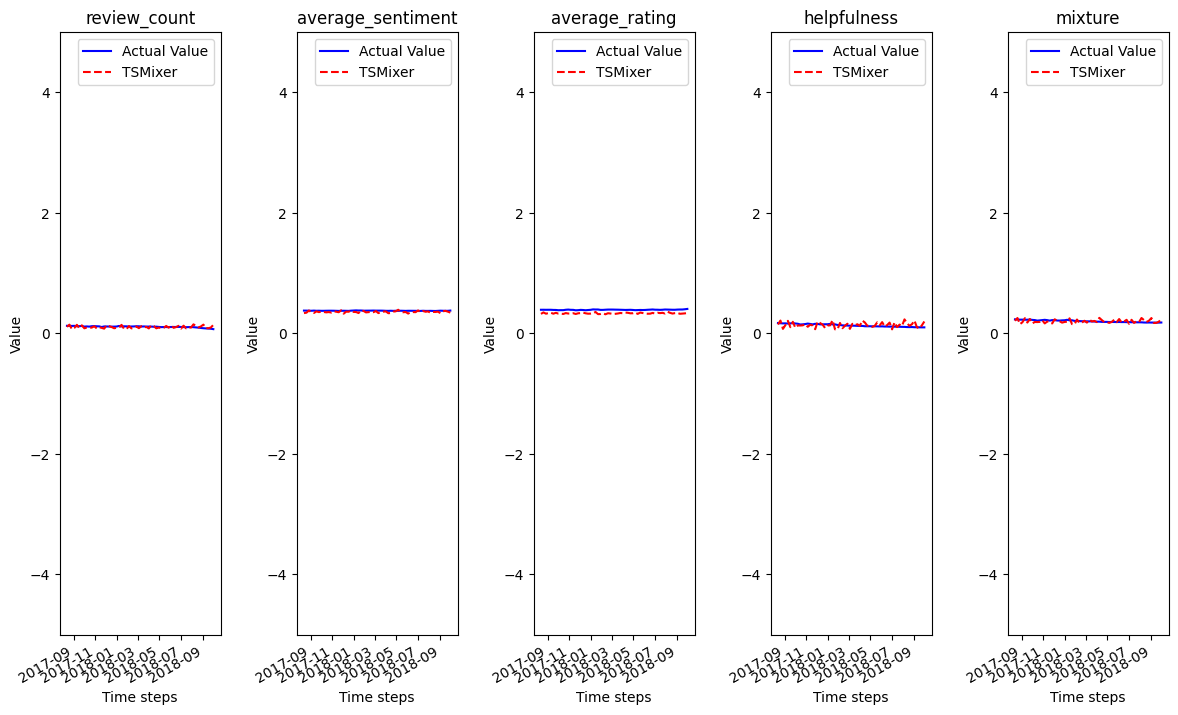

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12,8))

for i, ax in enumerate(axes.flatten()[0:5]):
    col = cols[i]
    
    ax.plot(df_grouped.index[-pred_len:], df_grouped_bak[col][-pred_len:], label = 'Actual Value', color='blue')
    ax.plot(df_grouped.index[-pred_len:], scaled_preds_df[col], label='TSMixer', ls='--', color='red')
    
    ax.legend(loc='best')
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Value')
    # if col == 'review_count':
    #     ax.set_ylim(0, 5)  # Set custom y-limit for 'review_count
    # else:
    ax.set_ylim(-5, 5) 
    ax.set_title(col)
    
plt.tight_layout()
fig.autofmt_xdate()

plt.savefig('RESULT_'+filename+'.jpg')

<h1>MSE</h1>

In [40]:
for column in cols:
    mse = ((df_grouped_bak[column][-pred_len:].values - scaled_preds_df[column].values) ** 2).mean()
    print('MSE('+column+')='+str(round(mse*100,5))+'%')

MSE(review_count)=0.06679%
MSE(average_sentiment)=0.05746%
MSE(average_rating)=0.34651%
MSE(helpfulness)=0.25086%
MSE(mixture)=0.11797%


In [41]:
actual_values = df_grouped_bak[column][-pred_len:].values
print(actual_values<0)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]


<h1>MSLE</h1>

In [42]:
for column in cols:
    msle = ((np.log1p(df_grouped_bak[column][-pred_len:].values) - np.log1p(scaled_preds_df[column].values)) ** 2).mean()
    print('MSLE('+column+')='+str(round(msle*100,5))+'%')

MSLE(review_count)=0.05459%
MSLE(average_sentiment)=0.03105%
MSLE(average_rating)=0.18694%
MSLE(helpfulness)=0.19256%
MSLE(mixture)=0.08146%


<h1>MAPE</h1>

In [43]:
for column in cols:
    # mape = (abs(df_grouped_bak[column][-pred_len:].values - scaled_preds_df[column].values) / df_grouped_bak[column][-pred_len:].values).mean()
    mape= (abs(df_grouped_bak[column][-pred_len:].values - scaled_preds_df[column].values / df_grouped_bak[column][-pred_len:].values)).mean() * 100
    print('MAPE('+column+')='+str(round(mape,5))+'%')
    

MAPE(review_count)=86.40353%
MAPE(average_sentiment)=57.27067%
MAPE(average_rating)=45.99125%
MAPE(helpfulness)=95.90597%
MAPE(mixture)=79.59971%


In [44]:
df_raw.shape

(10063255, 13)